In [ ]:
import zipfile
import os

zip_path = "/content/archive.zip"  #uploading Zip file
extract_to = "/content"  #extract to /content

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ ZIP extracted!")


✅ ZIP extracted!


In [ ]:
dataset_path = "/content/WM811k_Dataset"

# Checking what's inside
for root, dirs, files in os.walk(dataset_path):
    print(f"📁 Found {len(dirs)} subfolders and {len(files)} files in: {root}")
    if dirs:
        print("✨ Subfolder (class labels):", dirs)
    break


📁 Found 9 subfolders and 0 files in: /content/WM811k_Dataset
✨ Subfolder (class labels): ['Donut', 'random', 'none', 'Edge Local', 'Local', 'Scratch', 'Edge Ring', 'near full', 'Center']


In [ ]:
import os
import shutil
import random
from zipfile import ZipFile

# Unzip
with ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

# Define source and destination
src_dir = '/content/WM811k_Dataset'
train_dir = '/content/train'
val_dir = '/content/val'

# Create folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# For each class folder (Center, Donut, etc.)
for class_name in os.listdir(src_dir):
    class_path = os.path.join(src_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    split_idx = int(0.8 * len(images))  # 80% train
    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training images get augmented
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation images just get rescaled
val_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/val',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)


Found 895 images belonging to 9 classes.
Found 451 images belonging to 9 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

# 1st Convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # helps avoid overfitting

# Output layer (9 classes, so 9 units + softmax)
model.add(Dense(9, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,313 (6.20 MB)

 Trainable params: 1,626,313 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.2061 - loss: 2.1133 - val_accuracy: 0.4302 - val_loss: 1.4933
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.3601 - loss: 1.6220 - val_accuracy: 0.5188 - val_loss: 1.3963
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.4438 - loss: 1.4951 - val_accuracy: 0.6075 - val_loss: 1.1836
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.5373 - loss: 1.3021 - val_accuracy: 0.6918 - val_loss: 0.9813
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.5376 - loss: 1.1547 - val_accuracy: 0.6896 - val_loss: 0.8542
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.6635 - loss: 0.9716 - val_accuracy: 0.6829 - val_loss: 0.9082
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.6157 - loss: 1.0994 - val_accuracy: 0.7095 - val_loss: 0.8474
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 268ms/step - accuracy: 0.6539 - loss: 0.9535 - val_accuracy

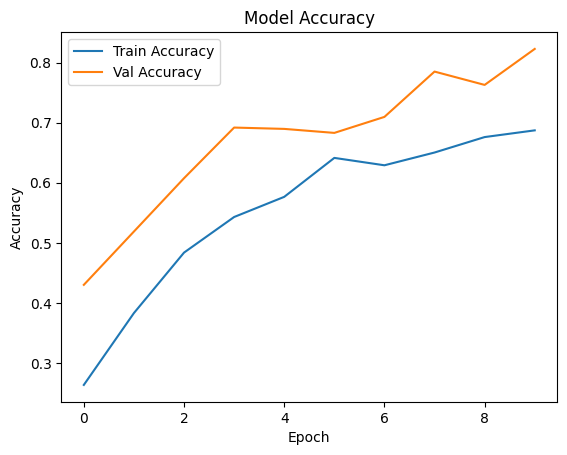

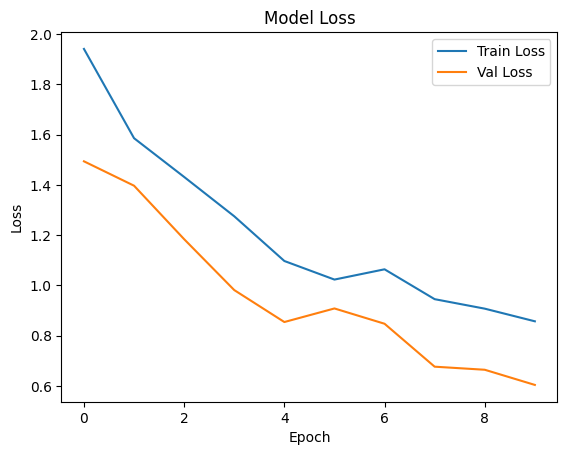

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
img_path = '/content/val/Donut/679825.jpg'

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize same as training

In [ ]:
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)

# Map index back to class label
class_labels = list(train_generator.class_indices.keys())
predicted_class = class_labels[predicted_class_index]

print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Predicted Class: Donut
